In [1]:
import json
import numpy as np
import random
from tqdm import tqdm
import nltk
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
import pandas as pd
from sklearn.decomposition import PCA, TruncatedSVD
import re
import matplotlib.pyplot as plt
import sklearn
import scipy
from sklearn.preprocessing import normalize
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.neural_network import MLPClassifier


In [2]:
def rand_emot():
    e = ["(o_o)",":-)",":P",":D","x)","ᓚᘏᗢ","╯°□°）╯︵ ┻━┻",":)",
         "*<:-)","^_^","(⌐■_■)","¯\_(ツ)_/¯", "(T_T)",":o","OwO",
        "( ͡❛ ͜ʖ ͡❛)","(̶◉͛‿◉̶)","( ≖.≖)","(ㆆ_ㆆ)","ʕ•́ᴥ•̀ʔっ","( ◡́.◡̀)","(^◡^ )"]
    return random.choice(e)

def load_files():
    text_pairs = [] #Would be nice to have as np.array
    labels = []
    fandom = []
    
    pair_id = []
    true_id = []
    
    #Load truth JSON
    for line in open('data/modified/train_truth.jsonl'):
        d = json.loads(line.strip())
        labels.append(int(d['same']))
        true_id.append(d['id'])

    #Load actual fanfic.
    print("loading fanfic...",rand_emot())
    for line in tqdm(open('data/modified/train_pair.jsonl')):
        d = json.loads(line.strip())
        text_pairs.append(d['pair'])
        fandom.append(d['fandoms'])
        pair_id.append(d['id'])

    print("done loading",rand_emot())
    
    return text_pairs, labels, fandom, pair_id, true_id

In [3]:
text_pairs, labels, fandom, pair_id, true_id = load_files()

297it [00:00, 2963.26it/s]

loading fanfic... ¯\_(ツ)_/¯


1578it [00:00, 2815.37it/s]

done loading :P


In [4]:
text_pairs.pop(713)
labels.pop(713)

1

In [5]:
def create_corpus(text_pairs):
    '''input all text pairs to create a corpus'''
    corpus = [x[i] for x in text_pairs for i in range(len(x))]
    return corpus

In [6]:
corpus = create_corpus(text_pairs)
labels = labels

## PCA Function

In [7]:
def show_me_pca(vector, labels, is_pairs=False, title=""):
    '''Plot PCA for the two classes. Input is one long vector/list, it creates pairs itself.
    If you already created pairs, use is_pairs=True
    Example: if vector is distance between pairs, do not set is_pairs to True. 
    (as it is one vector describing both documents.)
    
    labels is simply a vector with the labels, which will be used to colour the scatter plot.'''
    
    #Convert labels to np.array (might be a list.)
    labels = np.array(labels)
    
    #Join pairs into one, long vector if necessary. 
    if not is_pairs:
        if scipy.sparse.issparse(vector):
            vector = [np.hstack([vector[x],vector[x+1]]) for x in range(0,vector.shape[0],2)]  
        else:
            vector = [np.hstack([vector[x],vector[x+1]]) for x in range(0,len(vector),2)]  
    
    #Get that PCA - Use SVD if vector is sparse.
    if scipy.sparse.issparse(vector):
        
        pca = TruncatedSVD(n_components=2)
    else:
        pca = PCA(n_components=2)
    pcs = pca.fit_transform(vector)
    
    #Printing pcs shape - remember they might be halved, due to pairing. 
    print(pcs.shape)
    
    #Group PC's into two, according to label indices. 
    group1 = pcs[labels==0]
    group2 = pcs[labels==1]
    
    #Plot that shit!
    plt.scatter(group1[:,0], group1[:,1], s=5)
    plt.scatter(group2[:,0], group2[:,1], s=5)
    plt.title(title)

## Function Word Feature Exploration

In [8]:
#Isolate function words

with open('data/function_words_clean.txt', "r") as fw:
    func_words = fw.read().split()

def isolate_fw(corpus, f_words): #data must be json file - input must be path to file 
    fw_in_data = []

    for text in tqdm(corpus):
        function_words = []
        words = text.split() #split fanfic into words in list
        for word in words: 
            if word in f_words: #if the word is a function word
                function_words.append(word)
                
        stringed_function_words = " ".join(function_words)
        
        #append all function words as one long string in a list
        fw_in_data.append(stringed_function_words) #fw_in_data is a list with strings
        #each list contains a string of all function words for each pair
        #should it be a string for each pair?
        
    return fw_in_data

In [9]:
function_words = isolate_fw(corpus, func_words)
fw_tokens = [nltk.word_tokenize(x) for x in function_words]
unigram_freqdists = [nltk.FreqDist(x) for x in fw_tokens]
bigrams = [nltk.bigrams(x) for x in fw_tokens]
bigram_freqdists = [nltk.FreqDist(x) for x in bigrams]

100%|██████████████████████████████████████████████████████████████████████████████| 3154/3154 [00:31<00:00, 99.91it/s]


In [10]:
def get_mat_from_fdists(fdists):
    '''This function compiles a list of frequency distributions and create a matrix with feature vectors.
    Each row is a feature vector. Should would with all typed of dictionaries, actually.'''
    all_keys = list(set([item for sublist in fdists for item in sublist]))
    matrix = np.zeros((len(fdists),len(all_keys)))
    
    for i, fd in enumerate(tqdm(fdists)):
        for j, key in enumerate(all_keys):
            matrix[i,j] = fd[key]
    
    return matrix

In [11]:
v1 = normalize(get_mat_from_fdists(unigram_freqdists))
#v1 = normalize(get_mat_from_fdists(bigram_freqdists))

100%|███████████████████████████████████████████████████████████████████████████| 3154/3154 [00:00<00:00, 14072.35it/s]


(1577, 2)


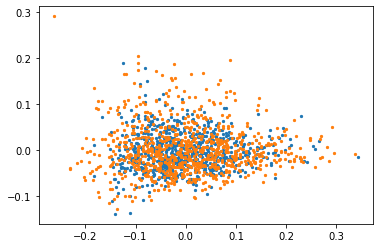

In [12]:
compile_pairs = [v1[x]*v1[x+1] for x in range(0,v1.shape[0],2)]
show_me_pca(compile_pairs, labels, is_pairs=True)

In [13]:
#x_train, x_test, y_train, y_test = train_test_split(compile_pairs, labels, random_state=42)

In [14]:
# nn = MLPClassifier()
# nn.fit(x_train, y_train)
# print(nn.score(x_test, y_test))
# result = permutation_importance(nn, x_train, y_train, n_repeats=3, random_state=42, n_jobs=4)
# means = result.importances_mean
# stds = result.importances_std

In [15]:
# sparse_x_train = np.array(x_train)
# sparse_x_train = sparse_x_train[:, means>0]
# sparse_x_test = np.array(x_test)
# sparse_x_test = sparse_x_test[:, means>0]

# nn.fit(sparse_x_train, y_train)
# nn.score(sparse_x_test, y_test)

In [16]:
#show_me_pca(sparse_x_train, y_train, is_pairs=True)

In [17]:
# def create_layer_setup(num=5, max_hidden=4, max_nodes=100):
#     output = []
#     for i in range(num):
#         output.append([])
    
#     for i in output:
#         for j in range(1, random.randint(1,max_hidden)+1):
#             i.append(random.randint(5,max_nodes))
    
#     return output

In [18]:
# #Boost that shit for real!

# best_score = 0
# best_params = []
# for i in tqdm(range(20)):
#     layers = create_layer_setup(num=20, max_hidden=6, max_nodes=200)
#     distributions = dict(hidden_layer_sizes=layers, activation=['relu','tahn','logistic'],
#                         learning_rate=['constant', 'adaptive', 'invscaling'], )
#     clf = RandomizedSearchCV(nn, distributions, random_state=42, n_jobs=6)
#     search = clf.fit(sparse_x_train, y_train)
    
#     params = search.best_params_
#     score = clf.score(sparse_x_test, y_test)
    
#     if score > best_score:
#         best_score = score
#         best_params = params

# print(best_score, best_params)

In [19]:
def create_character_ngram(n, corpus):
    #Will return matrix where each row is a pair of texts
    vectorizer = TfidfVectorizer(max_features=3000, analyzer='char',ngram_range=(n, n))
    char_bigram = vectorizer.fit_transform(corpus).toarray()
    return np.array([np.concatenate((char_bigram[x], char_bigram[x+1])) for x in range(0,char_bigram.shape[0],2)])

In [20]:
char_bigrams = create_character_ngram(2, corpus)

## Save features

In [40]:
import pickle
def save_features(feature_dict, filename='features'):
    '''Save the updated feature dictionary. Takes dictionary as input and saves as binary file
    
    example: 
    >>> my_featues = {'freqdist': [1,6,3,5]}
    >>> save_features(my_features)'''
    
    with open('data/{}.dat'.format(filename), 'wb') as file:
        pickle.dump(feature_dict, file)
    print("Features saved! :-)")

def load_features(filename='features'):
    '''Load feature dictionary. Returns the saved feature as a dictionary.
    
    example: 
    >>> my_features = load_features()'''
    
    with open('data/{}.dat'.format(filename), 'rb') as file:
        feats = pickle.load(file)
    print("Features available:")
    for i in feats.keys():
        print(i)
    return feats

In [22]:
# f = {'function_words_freq_dist':v1,
#     'character_bigram':char_bigrams}
# save_features(f)

## Skip-gram

In [23]:
#Stolen from https://stackoverflow.com/questions/31847682/how-to-compute-skipgrams-in-python
from itertools import chain, combinations
import copy
from nltk.util import ngrams

corpus_tokens = [nltk.word_tokenize(x) for x in corpus]

def pad_sequence(sequence, n, pad_left=False, pad_right=False, pad_symbol=None):
    if pad_left:
        sequence = chain((pad_symbol,) * (n-1), sequence)
    if pad_right:
        sequence = chain(sequence, (pad_symbol,) * (n-1))
    return sequence

def skipgrams(sequence, n, k, pad_left=False, pad_right=False, pad_symbol=None):
    sequence_length = len(sequence)
    sequence = iter(sequence)
    sequence = pad_sequence(sequence, n, pad_left, pad_right, pad_symbol)

    if sequence_length + pad_left + pad_right < k:
        raise Exception("The length of sentence + padding(s) < skip")

    if n < k:
        raise Exception("Degree of Ngrams (n) needs to be bigger than skip (k)")    

    history = []
    nk = n+k

    # Return point for recursion.
    if nk < 1: 
        return
    # If n+k longer than sequence, reduce k by 1 and recur
    elif nk > sequence_length: 
        for ng in skipgrams(list(sequence), n, k-1):
            yield ng

    while nk > 1: # Collects the first instance of n+k length history
        history.append(next(sequence))
        nk -= 1

    # Iterative drop first item in history and picks up the next
    # while yielding skipgrams for each iteration.
    for item in sequence:
        history.append(item)
        current_token = history.pop(0)      
        # Iterates through the rest of the history and 
        # pick out all combinations the n-1grams
        for idx in list(combinations(range(len(history)), n-1)):
            ng = [current_token]
            for _id in idx:
                ng.append(history[_id])
            yield tuple(ng)

    # Recursively yield the skigrams for the rest of seqeunce where
    # len(sequence) < n+k
    for ng in list(skipgrams(history, n, k-1)):
        yield ng

In [24]:
def create_skip_gram(n=2, k=2, input_text):
    #Creates count vector of skip-gram of text. (Output is paired)
    n,k=2,2
    vectorizer = TfidfVectorizer(max_features=4000, ngram_range=(n, n))
    skipgram = []
    for i in range(len(input_text)):
        #Join skipgrams to one single text for tfidf - will use ngrams anyway.
        skipgram.append(' '.join([' '.join(x) for x in list(skipgrams(input_text[i], n=n, k=k))]))

    fd_mat = vectorizer.fit_transform(skipgram).toarray()
    return np.array([np.concatenate((fd_mat[x], fd_mat[x+1])) for x in range(0,len(skipgram)-1,2)])

skipgram_bigram = create_skip_gram(corpus_tokens)

In [34]:
#pos_tags = [nltk.pos_tag(x) for x in corpus_tokens]
POS_skipgram = create_skip_gram(pos_tags)

In [36]:
POS_skipgram.shape

(1577, 8000)

In [37]:
f = {'function_words_freq_dist':v1, #Not paired
     'character_bigram':char_bigrams, #paired
     'skip_bigram': skipgram_bigram,
    'pos_skipgram': POS_skipgram} #paired
save_features(f)

Features saved! :-)


In [31]:
skipgram_bigram[0]

array([0.01112369, 0.02180506, 0.01574332, ..., 0.01103642, 0.01096536,
       0.        ])

In [41]:
feats = load_features()

Features available:
function_words_freq_dist
character_bigram
skip_bigram
pos_skipgram


In [44]:
feats['pos_skipgram'].shape

(1577, 8000)